# Particle Localization

We'll build a neural network to determine the position of particles within an image

## Load Data

We'll use a dataset including two videos of optically trapped particles.

In [1]:
import os
import glob

if not os.path.exists("particle_dataset"):
    os.system("git clone -b cm https://github.com/DeepTrackAI/particle_dataset")

train_path = os.path.join("particle_dataset", "particle_dataset")
train_video_path = glob.glob(os.path.join(train_path, "*.avi"))

print(f"{len(train_video_path)} training videos")

2 training videos


We'll define a function to load the videos
```python
def load_video(path, frames_to_load=100, image_size=51):
    video = cv2.VideoCapture(path)
    data = []
    for _ in range(frames_to_load):
        (_, frame) = video.read()
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        frame = cv2.resize(frame, (image_size, image_size))
        data.append(frame)
    return np.array(data)
```
and use it to read the data.

In [2]:
from fnc_particle_loc import load_video

low_noise_data = load_video(train_video_path[1])
high_noise_data = load_video(train_video_path[0])

We'll plot the first 6 frames of each video.

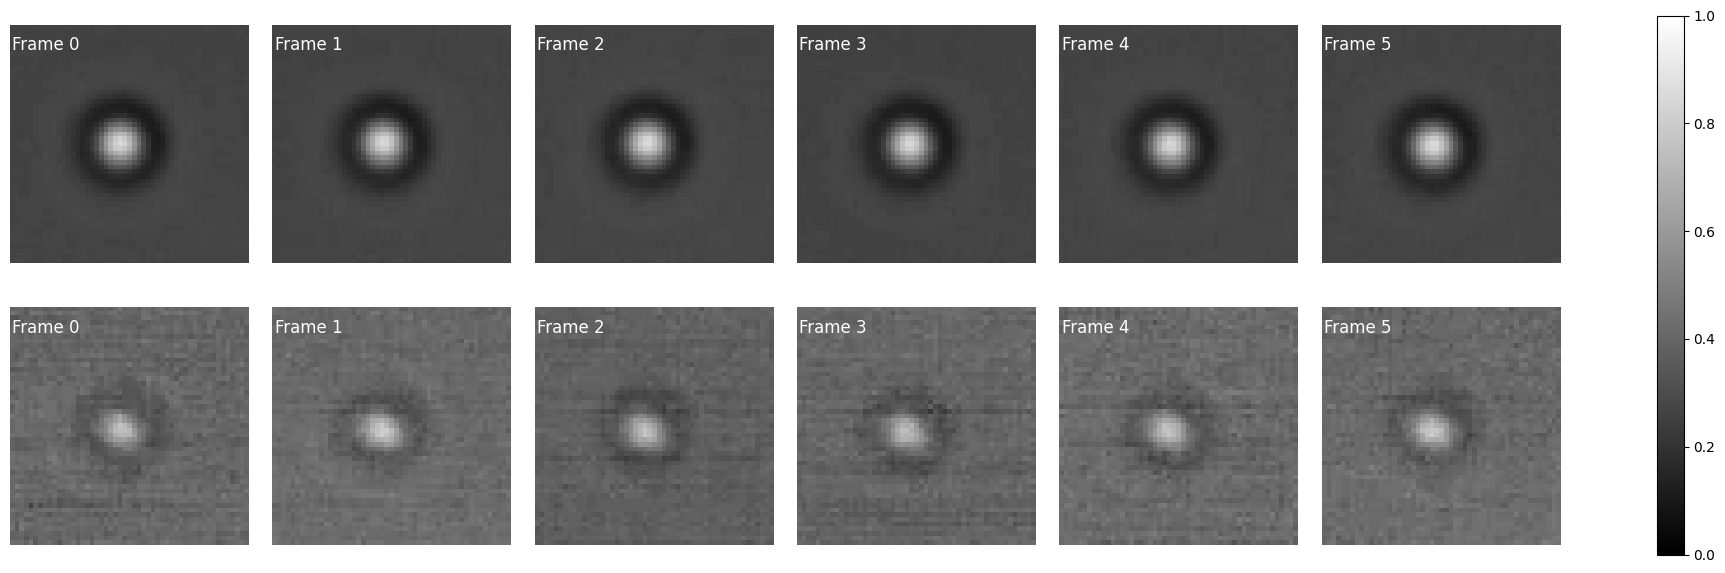

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 6, figsize=(25, 7))
for i in range(6):
    im = ax[0, i].imshow(low_noise_data[i], vmin=0, vmax=1, cmap="gray")
    ax[0, i].text(0, 5, "Frame {}".format(i), color="white", fontsize=12)

    ax[0, i].axis("off")
    ax[1, i].imshow(high_noise_data[i], vmin=0, vmax=1, cmap="gray")
    ax[1, i].text(0, 5, "Frame {}".format(i), color="white", fontsize=12)
    ax[1, i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.colorbar(im, ax=ax.ravel().tolist())
plt.show()

## Data manual annotation

We'll define a class to be able to interactively select the centroid of particles in some of the video frames.

```python
class ParticleCenter:

    def __init__(self, images):
        self.images = images
        self.positions = []
        self.i = 0
        self.fig, self.ax = plt.subplots(1, 1, figsize=(5, 5))
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False

    def start(self):
        self.im = self.ax.imshow(self.images[self.i], cmap="gray", vmin=0, vmax=1)
        self.text = self.ax.text(
            3,
            5,
            "Frame " + str(self.i + 1) + " of " + str(len(self.images)),
            color="white",
            fontsize=12,
        )
        self.ax.axis("off")
        self.cursor = Cursor(self.ax, useblit=True, color="red", linewidth=1)
        self.cid = self.fig.canvas.mpl_connect("button_press_event", self.onclick)
        self.next_image()
        plt.show()

    def next_image(self):
        im = self.images[self.i]
        self.im.set_data(im)
        self.text.set_text("Frame " + str(self.i + 1) + " of " + str(len(self.images)))
        self.fig.canvas.draw_idle()

    def onclick(self, event):
        self.positions.append([event.xdata, event.ydata])
        if self.i < len(self.images) - 1:
            self.i += 1
            self.next_image()
        else:
            self.fig.canvas.mpl_disconnect(self.cid)
            plt.close()
            return
```

We'll randomly select `number_of_images_to_annotate` frames a pinpoint the particle center.

In [4]:
# import numpy as np
# from fnc_particle_loc import ParticleCenter
# from numpy.random import choice

# %matplotlib ipympl
# # Needed for using the interactive features of matplotlib in Notebooks

# number_of_images_to_annotate = 100

# dataset = np.concatenate([low_noise_data, high_noise_data], axis=0)
# np.random.shuffle(dataset)

# images_to_annotate = choice(
#   np.arange(dataset.shape[0]),
#   number_of_images_to_annotate,
#   replace=False
# )

# pc = ParticleCenter(dataset[images_to_annotate])
# pc.start()

# annotated_data = pc.images
# labels = pc.positions

# %matplotlib inline
# # Back to normal matplotlib backend

We'll save the annotated images and the corresponding centroid positions in two files.

In [5]:
# np.save(
#     os.path.join(train_path, "annotated_data.npy"),
#     np.array(annotated_data),
# )

# np.save(
#     os.path.join(train_path, "annotated_data_labels.npy"),
#     np.array(labels),
# )

## Dataset preprocessing

We'll use the annotated data to train and test a CNN. First, we define a `Dataset` class to provide the data in the needed format.

```python
class ParticleDataset(Dataset):
    import torch
    import numpy as np

    def __init__(self, file, dir):
        self.im = np.load(os.path.join(dir, file))
        name, ext = os.path.splitext(file)
        self.pos = np.load(os.path.join(dir, name + "_labels" + ext))

    def __len__(self):
        return self.im.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.im[idx, np.newaxis, :, :]).float()
        labels = torch.tensor(self.pos[idx] / self.im.shape[1] - 0.5).float()
        sample = [img, labels]
        return sample
```
The `ParticleDataset` class reads the annotated data, transform the images into torch tensors and rescales the centroid positions in [-1.1].

In [6]:
import torch
from fnc_particle_loc import ParticleDataset

annotated_dataset = ParticleDataset("annotated_data.npy", train_path)

We'll split the annotated data and define two data loaders.

In [7]:
import deeplay as dl
from torch.utils.data import random_split

train_ann_dataset, test_ann_dataset = random_split(annotated_dataset, [0.8, 0.2])

train_ann_dataloader = dl.DataLoader(train_ann_dataset, batch_size=1)
test_ann_dataloader = dl.DataLoader(test_ann_dataset, batch_size=1)

## Convolutional Neural Network

We define a CNN with a dense top to analyze the images using `deeplay`.

In [8]:
import torch.nn
from fnc_particle_loc import Flatten

CNN = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1,
        hidden_channels=[16, 32],
        out_channels=64,
        pool=torch.nn.MaxPool2d(
            kernel_size=2,
        ),
        out_activation=torch.nn.ReLU,
    ),
    dl.Layer(torch.nn.MaxPool2d, kernel_size=2),
    dl.Layer(Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64,
        hidden_features=[32, 32],
        out_features=2,
        out_activation=torch.nn.Identity,
    ),
)

print(CNN)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identit

We then compile the CNN as a regressor.

In [9]:
import torchmetrics as tm

regressor_template = dl.Regressor(
    model=CNN,
    loss=torch.nn.MSELoss(),
    optimizer=dl.Adam(),
    metrics=[tm.MeanAbsoluteError()],
)

CNN_regressor = regressor_template.create()

## Train

We train the CNN regressor...

In [10]:
CNN_trainer = dl.Trainer(
    max_epochs=50,  # How many times to run through the entire dataset
    accelerator="auto",  # Use GPU if available
)

CNN_trainer.fit(CNN_regressor, train_ann_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2023-12-08 18:33:08.348565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


... and evaluate its performance over the training set. We also calculate the mean absolute error in pixel units.

In [ ]:
test_results = CNN_trainer.test(CNN_regressor, test_ann_dataloader)

IMAGE_SIZE = test_ann_dataset[0][0].shape[1]
print(
    "Mean pixel error: {:.3f} pixels".format(
        test_results[0]["testMeanAbsoluteError_epoch"] * IMAGE_SIZE
    )
)

In [ ]:
# OLD IMPLEMENTATION
# def mean_pixel_error(y_true, y_pred):
#     return np.mean(np.abs(np.array(y_true) - np.array(y_pred))) * IMAGE_SIZE


# test_lab, test_pred = [], []
# for td_im, td_lab in test_dataset:
#     test_pred.append(CNN_regressor(td_im.unsqueeze(0))[0].detach())
#     IMAGE_SIZE = test_dataset[idx][0].shape[1]
#     test_lab.append(td_lab)


# print("Mean pixel error: {:.3f} pixels".format(mean_pixel_error(test_lab, test_pred)))

## Visualization

We compare annotated and predicted particle positions.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

random_idx = np.random.choice(np.arange(len(test_ann_dataset)), 10, replace=False)

for idx, ax in zip(random_idx, axes.flatten()):
    test_pred = CNN_regressor(test_ann_dataset[idx][0].unsqueeze(0))[0].detach()

    ax.imshow(test_ann_dataset[idx][0].detach().numpy().squeeze(), cmap="gray")
    ax.scatter(
        test_pred[0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_pred[1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="x",
        c="r",
        s=100,
        label="prediction",
    )
    ax.scatter(
        test_ann_dataset[idx][1][0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_ann_dataset[idx][1][1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="+",
        c="g",
        s=100,
        label="annotation",
    )
    ax.set_axis_off()
ax.legend(loc=(0.2, 0.8), framealpha=1)
plt.show()

## IMAGE SIMULATIONS
We will use the `deeptrack2.0` library to simulate particle images for which the ground truth is known. In these way we avoid the manual annotation and can have more data available for training.

The particle is defined using the deeptrack object `MieSphere`.

In [ ]:
from deeptrack.scatterers import MieSphere

particle = MieSphere(
    position=(25, 25),
    z=0,
    radius=300e-9,
    refractive_index=1.37,
    position_unit="pixel",
)

Then, we specify the optical device to image the particle.

In [ ]:
from deeptrack.optics import Brightfield

brightfield_microscope = Brightfield(
    wavelength=500e-9,
    NA=0.8,
    resolution=1e-6,
    magnification=15,
    refractive_index_medium=1.33,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

We create the image of the particle and display it.

In [ ]:
imaged_particle = brightfield_microscope(particle)

fig = plt.figure()
output_image = imaged_particle.resolve()
plt.imshow(np.squeeze(output_image), cmap="gray")
plt.axis("off")
plt.show()

We create particles with random positions arounf the center and display them.

In [ ]:
particle = MieSphere(
    position=lambda: np.random.uniform(IMAGE_SIZE / 2 - 3, IMAGE_SIZE / 2 + 3, 2),
    z=lambda: np.random.uniform(-1, -1),
    radius=lambda: np.random.uniform(300, 500) * 1e-9,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)
imaged_particle = brightfield_microscope(particle)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
for i, ax in enumerate(axes.flatten()):
    output_image = imaged_particle.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

We also add some Poisson noise to make the images more realistic.

In [ ]:
from deeptrack import Poisson

noise = Poisson(
    min_snr=3,
    max_snr=20,
    snr=lambda min_snr, max_snr: min_snr + np.random.rand() * (max_snr - min_snr),
    background=1,
)

noisy_imaged_particle = imaged_particle >> noise

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
for i, ax in enumerate(axes.flatten()):
    output_image = noisy_imaged_particle.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

Finally, we create a pipeline that generates noisy particle images and normalize the pixel values. 

In [ ]:
from deeptrack import NormalizeMinMax

normalization = NormalizeMinMax(
    lambda: np.random.rand() * 0.2, lambda: 0.8 + np.random.rand() * 0.2
)
data_pipeline = noisy_imaged_particle >> normalization

We also define a function to exctract the particle centroid position from the image
```python
def get_label(image):
    from numpy import array
    position = array(image.get_property("position"))
    return position
```
We display some images with the corresponding ground truth position.

In [ ]:
from fnc_particle_loc import get_label

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flatten()):
    output_image = data_pipeline.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")

    particle_position = get_label(output_image)
    ax.scatter(
        particle_position[1],
        particle_position[0],
        s=60,
        facecolors="none",
        edgecolor="g",
        linewidth=4,
    )

    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

We want to use the simulations for the CNN training. Thus, we modify the class `ParticleDataset` to now work with the simulation pipeline, creating the new class `ParticleDatasetSimul`
```python
class ParticleDatasetSimul(Dataset):
    import torch
    import numpy as np

    def __init__(self, pipeline, data_size):
        im = [pipeline.update().resolve() for _ in range(data_size)]
        self.pos = np.array([get_label(image) for image in im])
        self.im = np.array(im).squeeze()

    def __len__(self):
        return self.im.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.im[idx, np.newaxis, :, :]).float()
        labels = torch.tensor(self.pos[idx] / self.im.shape[1] - 0.5).float()
        sample = [img, labels]
        return sample
```
The class can be used with the data loader and passed to the CNN for training.

In [ ]:
from fnc_particle_loc import ParticleDatasetSimul

train_dataloader = dl.DataLoader(
    ParticleDatasetSimul(pipeline=data_pipeline, data_size=1000), batch_size=32
)

CNN_simul_regressor = regressor_template.create()

CNN_simul_trainer = dl.Trainer(
    max_epochs=50,
    accelerator="auto",
)

CNN_simul_trainer.fit(CNN_simul_regressor, train_dataloader)

We check the network performance on a simulated test dataset and on the annotated test dataset.

In [ ]:
test_dataloader = dl.DataLoader(
    ParticleDatasetSimul(pipeline=data_pipeline, data_size=100), batch_size=32
)

test_simul_results = CNN_simul_trainer.test(CNN_simul_regressor, test_dataloader)

print(
    "Mean pixel error: {:.3f} pixels".format(
        test_simul_results[0]["testMeanAbsoluteError_epoch"] * IMAGE_SIZE
    )
)

In [ ]:
test_ann_results = CNN_simul_trainer.test(CNN_simul_regressor, test_ann_dataloader)

print(
    "Mean pixel error: {:.3f} pixels".format(
        test_ann_results[0]["testMeanAbsoluteError_epoch"] * IMAGE_SIZE
    )
)

In [ ]:
val_prediction = val_predicted_positions
val_labels = np.array(val_labels)  1
fig, axs = plt.subplots(1, 2)
for i, axis in enumerate(["x", "y"]):
label = val_labels[:, i]  2
prediction = val_prediction[:, i]  3
axs[i].scatter(label, prediction, alpha=0.1)  4
axs[i].plot([np.min(label), np.max(label)], [np.min(label), np.max(label
)], c=’k’) 5
axs[i].set_xlabel("Prediction")
  axs[i].set_ylabel("Label")
  axs[i].set_xlim([-0.065, 0.065])
  axs[i].set_ylim([-0.065, 0.065])
axs[i].set_title("{i}-coordinates".format(i=axis)) for ax in fig.get_axes():
 ax.label_outer()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for idx, ax in zip(random_idx, axes.flatten()):
    test_pred = CNN_simul_regressor(test_ann_dataset[idx][0].unsqueeze(0))[0].detach()

    ax.imshow(test_ann_dataset[idx][0].detach().numpy().squeeze(), cmap="gray")
    ax.scatter(
        test_pred[0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_pred[1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="x",
        c="r",
        s=100,
        label="prediction",
    )
    ax.scatter(
        test_ann_dataset[idx][1][0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_ann_dataset[idx][1][1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="+",
        c="g",
        s=100,
        label="annotation",
    )
    ax.set_axis_off()
ax.legend(loc=(0.2, 0.8), framealpha=1)
plt.show()